## Predicting Telecom Client Churn

This project is for the telecom operator, Interconnect, a telecommunications and internet provider. They would like to be able to forecast their churn of clients. If it's discovered that a client is planning to leave, they will be offered promotional codes and special plan options.
In order to assist Intercom, we will be analyzing customer data in order to create a model with machine learning to help aid in the evaluation and identification of customers who will likely churn, or end their contracts.

Interconnect's marketing team has given us access to some of their clientele's personal data, including information about their plans and contracts. We need to analyze the data, and train a model to forecast if a client is going to stay or leave based on the data provided.
Our assessment metric for this task is ROC-AUC, or the Area Under Curve (AUC) of the Recieving Operator Characteristic (ROC). The closer to 1 the ROC-AUC score, the better the model's ability to predict accurately.

## Table of Contents

1. General Information
2. Data Preprocessing
3. Exploratory Data Analysis
4. Model Training
5. Conclusion

## General Information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer

Next we load the data

In [2]:
data_phone = pd.read_csv("/datasets/final_provider/phone.csv")

data_personal = pd.read_csv("/datasets/final_provider/personal.csv")

data_contract = pd.read_csv("/datasets/final_provider/contract.csv")

data_internet = pd.read_csv("/datasets/final_provider/internet.csv")

### Data Overview

In [3]:
data_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


### Preprocessing

In [5]:
#Convert column names to lower case and snake_script
data_contract = data_contract.rename(columns={'customerID' : 'customer_id', 'BeginDate' : 'begin_date', 
                                              'EndDate' : 'end_date', 'Type' : 'contract_type', 
                                              'PaperlessBilling' : 'paperless_billing', 'PaymentMethod' : 'payment_method', 
                                              'MonthlyCharges' : 'monthly_charges', 'TotalCharges' : 'total_charges'})

In [6]:
data_contract

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [7]:
#Convert Month-to-month within type column to Monthly

data_contract['contract_type'] = data_contract['contract_type'].where(data_contract['contract_type'] !=
                                                                     'Month-to-month', 'Month')

In [8]:
data_contract['contract_type'].value_counts()

Month       3875
Two year    1695
One year    1473
Name: contract_type, dtype: int64

In [9]:
# Convert begin_date to datetime
data_contract['begin_date'] = pd.to_datetime(data_contract['begin_date'], format='%Y-%m-%d')

# Convert end_date to datetime
data_contract['end_date'] = data_contract['end_date'].where(data_contract['end_date'] != 'No', None)
data_contract['end_date'] = pd.to_datetime(data_contract['end_date'], format='%Y-%m-%d')

In [10]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   contract_type      7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 440.3+ KB


We will create a column named 'contract_duration_months' by getting the difference between the EndDate and BeginDate.

In [11]:
# Create contract duration column
duration = ((data_contract['end_date'] - data_contract['begin_date']) / np.timedelta64(1, 'M'))
data_contract['contract_duration_months'] = duration.round()

We will create a column named **churned**. The active customers with Interconnect will be labeled as 0, and the customers that have stopped their subscription to Interconnect will be labeled 1. Then, the values in the column will be converted to integers.

In [12]:
# Create churned column
data_contract['churned'] = data_contract['contract_duration_months']
data_contract['churned'] = data_contract['churned'].fillna(0)
data_contract['churned'] = data_contract['churned'].where(data_contract['churned'] < 0.5, 1)
data_contract['churned'] = data_contract['churned'].astype(int)

For the paperless billing column, there are two answers, namely: Yes and No. We would make these answers in this column binary. Yes, will be converted to 1, and No, will be indicated with 0.

In [13]:
# Converting papaperless_billing to a binary classification
data_contract['paperless_billing'] = data_contract['paperless_billing'].where(data_contract['paperless_billing'] != 'Yes', 1)
data_contract['paperless_billing'] = data_contract['paperless_billing'].where(data_contract['paperless_billing'] != 'No', 0)
data_contract['paperless_billing'] = data_contract['paperless_billing'].astype(int)

In [14]:
data_contract

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,contract_duration_months,churned
0,7590-VHVEG,2020-01-01,NaT,Month,1,Electronic check,29.85,29.85,NaN,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.5,NaN,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month,1,Mailed check,53.85,108.15,2.0,1
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,NaN,0
4,9237-HQITU,2019-09-01,2019-11-01,Month,1,Electronic check,70.70,151.65,2.0,1
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,1,Mailed check,84.80,1990.5,NaN,0
7039,2234-XADUH,2014-02-01,NaT,One year,1,Credit card (automatic),103.20,7362.9,NaN,0
7040,4801-JZAZL,2019-03-01,NaT,Month,1,Electronic check,29.60,346.45,NaN,0
7041,8361-LTMKD,2019-07-01,2019-11-01,Month,1,Mailed check,74.40,306.6,4.0,1


Next, we change the datatype of the **total_charges** column to float

In [15]:
# total_charges to float
data_contract['total_charges'] = pd.to_numeric(data_contract['total_charges'], errors='coerce')

In [16]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_id               7043 non-null   object        
 1   begin_date                7043 non-null   datetime64[ns]
 2   end_date                  1869 non-null   datetime64[ns]
 3   contract_type             7043 non-null   object        
 4   paperless_billing         7043 non-null   int64         
 5   payment_method            7043 non-null   object        
 6   monthly_charges           7043 non-null   float64       
 7   total_charges             7032 non-null   float64       
 8   contract_duration_months  1869 non-null   float64       
 9   churned                   7043 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(2), object(3)
memory usage: 550.4+ KB


In [17]:
data_contract.head()

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,contract_duration_months,churned
0,7590-VHVEG,2020-01-01,NaT,Month,1,Electronic check,29.85,29.85,NaN,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,NaN,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month,1,Mailed check,53.85,108.15,2.0,1
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,NaN,0
4,9237-HQITU,2019-09-01,2019-11-01,Month,1,Electronic check,70.70,151.65,2.0,1


Taking out duplicates

In [18]:
data_contract.duplicated().sum()

0

### Personal

In [19]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [20]:
data_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


#### Preprocessing

First, we convert the column names to lower case and separate them with an underscore

In [21]:
# Converting from upper case to lower case
data_personal.rename(columns=lambda x: x.lower(), inplace = True)

In [22]:
# Convert column names to snake_script
data_personal = data_personal.rename(columns={'customerid' : 'customer_id','gender' : 'gender' ,
                                          'seniorcitizen' : 'senior_citizen', 'partner' : 'partner', 'dependents' : 'dependents'})

For the gender column, there are two separate categories, namely male and female. We will make a binary classification. The males will be classified 1, the females will be classified 0

In [23]:
# Classifying the gender column as Binary
data_personal['gender'] = data_personal['gender'].where(data_personal['gender'] != 'Male', 1)
data_personal['gender'] = data_personal['gender'].where(data_personal['gender'] != 'Female', 0)
data_personal['gender'] = data_personal['gender'].astype(int)

The same Binary classification will be done on the **partner** column. Yes, would be assigned the value 1, and No will be assigned the value 0

In [24]:
# Classifying the partner column as Binary
data_personal['partner'] = data_personal['partner'].where(data_personal['partner'] != 'Yes', 1)
data_personal['partner'] = data_personal['partner'].where(data_personal['partner'] != 'No', 0)
data_personal['partner'] = data_personal['partner'].astype(int)

For the **dependents** column Binary classification will also be performed. Yes, would be assigned the value 1, and No will be assigned the value 0.

In [25]:
# Classifying the dependents
data_personal['dependents'] = data_personal['dependents'].where(data_personal['dependents'] != 'Yes', 1)
data_personal['dependents'] = data_personal['dependents'].where(data_personal['dependents'] != 'No', 0)
data_personal['dependents'] = data_personal['dependents'].astype(int)

In [26]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   int64 
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   int64 
 4   dependents      7043 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 275.2+ KB


In [27]:
data_personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0


In [28]:
data_personal.duplicated().sum()

0

### Internet

In [29]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [30]:
data_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


#### Preprocessing

For the Internet dataset. The preprocessing that will be done are:
1. Changing the column names to lower case
2. Converting the following columns: OnlineSecurity, OnlineBackup, DeviceProtection, TechSuppport, StreamingTV, and StreamingMovies to binary classifications.
Yes is indicated by 1, and No is indicated by 0

In [31]:
### Convert column names to snake_script
data_internet = data_internet.rename(columns={'customerID' : 'customer_id','InternetService' : 'internet_service' , 'OnlineSecurity' : 'online_security', 
                                              'OnlineBackup' : 'online_backup', 'DeviceProtection' : 'device_protection', 'TechSupport' : 'tech_support', 
                                              'StreamingTV' : 'streaming_tv', 'StreamingMovies' : 'streaming_movies'})

In [32]:
## Working on the Columns that need Binary Classification 
data_internet = data_internet.where(data_internet != 'Yes', 1)
data_internet = data_internet.where(data_internet != 'No', 0)
data_internet['online_security'] = data_internet['online_security'].astype(int)
data_internet['online_backup'] = data_internet['online_backup'].astype(int)
data_internet['device_protection'] = data_internet['device_protection'].astype(int)
data_internet['tech_support'] = data_internet['tech_support'].astype(int)
data_internet['streaming_tv'] = data_internet['streaming_tv'].astype(int)
data_internet['streaming_movies'] = data_internet['streaming_movies'].astype(int)

In [33]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   int64 
 3   online_backup      5517 non-null   int64 
 4   device_protection  5517 non-null   int64 
 5   tech_support       5517 non-null   int64 
 6   streaming_tv       5517 non-null   int64 
 7   streaming_movies   5517 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 344.9+ KB


In [34]:
data_internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0


In [35]:
data_internet.duplicated().sum()

0

### Phone

In [36]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [37]:
data_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [38]:
#Converting the names in the columns to lowercases
data_phone = data_phone.rename(columns = {'customerID': 'customer_id', 'MultipleLines' : 'multiple_lines'})

In [39]:
data_phone

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


Changing the multiple_lines column to a Binary classification

In [40]:
data_phone['multiple_lines'] = data_phone['multiple_lines'].where(data_phone['multiple_lines'] != 'Yes', 1)
data_phone['multiple_lines'] = data_phone['multiple_lines'].where(data_phone['multiple_lines'] != 'No', 0)
data_phone['multiple_lines'] = data_phone['multiple_lines'].astype(int)

In [41]:
data_phone

,customer_id,multiple_lines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1
...,...,...
6356,2569-WGERO,0
6357,6840-RESVB,1
6358,2234-XADUH,1
6359,8361-LTMKD,1


In [42]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 99.5+ KB


In [43]:
data_phone.duplicated().sum()

0

### Merging the DataFrames

 The next step will be to  merge all the tables on the customer_id column. 

In [44]:
data_complete = data_contract.merge(data_personal, on='customer_id', how='outer')
data_complete = data_complete.merge(data_internet, on='customer_id', how='outer')
data_complete = data_complete.merge(data_phone, on='customer_id', how='outer')

In [45]:
data_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_id               7043 non-null   object        
 1   begin_date                7043 non-null   datetime64[ns]
 2   end_date                  1869 non-null   datetime64[ns]
 3   contract_type             7043 non-null   object        
 4   paperless_billing         7043 non-null   int64         
 5   payment_method            7043 non-null   object        
 6   monthly_charges           7043 non-null   float64       
 7   total_charges             7032 non-null   float64       
 8   contract_duration_months  1869 non-null   float64       
 9   churned                   7043 non-null   int64         
 10  gender                    7043 non-null   int64         
 11  senior_citizen            7043 non-null   int64         
 12  partner             

In [46]:
data_complete.head()

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,contract_duration_months,churned,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month,1,Electronic check,29.85,29.85,NaN,0,...,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,NaN,0,...,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month,1,Mailed check,53.85,108.15,2.0,1,...,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,NaN,0,...,0,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month,1,Electronic check,70.70,151.65,2.0,1,...,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Preprocessing of data_complete

In [47]:
data_complete.isna().sum()

customer_id                    0
begin_date                     0
end_date                    5174
contract_type                  0
paperless_billing              0
payment_method                 0
monthly_charges                0
total_charges                 11
contract_duration_months    5174
churned                        0
gender                         0
senior_citizen                 0
partner                        0
dependents                     0
internet_service            1526
online_security             1526
online_backup               1526
device_protection           1526
tech_support                1526
streaming_tv                1526
streaming_movies            1526
multiple_lines               682
dtype: int64

In [48]:
data_complete[data_complete['total_charges'].isna()]

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,contract_duration_months,churned,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
488,4472-LVYGI,2020-02-01,NaT,Two year,1,Bank transfer (automatic),52.55,NaN,NaN,0,...,1,1,DSL,1.0,0.0,1.0,1.0,1.0,0.0,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,0,Mailed check,20.25,NaN,NaN,0,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
936,5709-LVOEQ,2020-02-01,NaT,Two year,0,Mailed check,80.85,NaN,NaN,0,...,1,1,DSL,1.0,1.0,1.0,0.0,1.0,1.0,0.0
1082,4367-NUYAO,2020-02-01,NaT,Two year,0,Mailed check,25.75,NaN,NaN,0,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1340,1371-DWPAZ,2020-02-01,NaT,Two year,0,Credit card (automatic),56.05,NaN,NaN,0,...,1,1,DSL,1.0,1.0,1.0,1.0,1.0,0.0,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,0,Mailed check,19.85,NaN,NaN,0,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3826,3213-VVOLG,2020-02-01,NaT,Two year,0,Mailed check,25.35,NaN,NaN,0,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4380,2520-SGTTA,2020-02-01,NaT,Two year,0,Mailed check,20.00,NaN,NaN,0,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5218,2923-ARZLG,2020-02-01,NaT,One year,1,Mailed check,19.70,NaN,NaN,0,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6670,4075-WKNIU,2020-02-01,NaT,Two year,0,Mailed check,73.35,NaN,NaN,0,...,1,1,DSL,0.0,1.0,1.0,1.0,1.0,0.0,1.0


In [49]:
data_complete['begin_date'].max()

Timestamp('2020-02-01 00:00:00')

It is seen that customer IDs that have no value for total_charges were those with a begin date of 2020-02-01, which is the latest date. It indicates that they have signed up for a service, but have not been charged yet, making the total charges to their accounts 0.

There are missing values in the following columns: internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, and multiple_lines. 
These missing values indicate that the customer did not have the service. The missing values in internet_service would be replaced with "No Service" as this column contained other strings such as "DSL" or "Fiber Optic". The missing values in the other columns will be filled with "0" as this indicates that they did not have this particular service.

In [50]:
data_complete['total_charges'] = data_complete['total_charges'].fillna(0)

In [51]:
data_complete['internet_service'] = data_complete['internet_service'].fillna('No Service')

In [52]:
#Filling the empty rows in online_security column with 0 

data_complete['online_security'] = data_complete['online_security'].fillna(0)
data_complete['online_security'] = data_complete['online_security'].astype(int)

In [53]:
#Filling the empty rows in online_backup column with 0 

data_complete['online_backup'] = data_complete['online_backup'].fillna(0)
data_complete['online_backup'] = data_complete['online_backup'].astype(int)

In [54]:
#Filling the empty rows in device_protection column with 0

data_complete['device_protection'] = data_complete['device_protection'].fillna(0)
data_complete['device_protection'] = data_complete['device_protection'].astype(int)

In [55]:
#Filling the empty rows in tech_support column with 0

data_complete['tech_support'] = data_complete['tech_support'].fillna(0)
data_complete['tech_support'] = data_complete['tech_support'].astype(int)

In [56]:
#Filling the empty rows in streaming_tv column with 0

data_complete['streaming_tv'] = data_complete['streaming_tv'].fillna(0)
data_complete['streaming_tv'] = data_complete['streaming_tv'].astype(int)

In [57]:
#Filling the empty rows in streaming_movies column with 0

data_complete['streaming_movies'] = data_complete['streaming_movies'].fillna(0)
data_complete['streaming_movies'] = data_complete['streaming_movies'].astype(int)

In [58]:
#Filling the empty rows in multiple_lines column with 0

data_complete['multiple_lines'] = data_complete['multiple_lines'].fillna(0)
data_complete['multiple_lines'] = data_complete['multiple_lines'].astype(int)

In [59]:
data_complete.isna().sum()

customer_id                    0
begin_date                     0
end_date                    5174
contract_type                  0
paperless_billing              0
payment_method                 0
monthly_charges                0
total_charges                  0
contract_duration_months    5174
churned                        0
gender                         0
senior_citizen                 0
partner                        0
dependents                     0
internet_service               0
online_security                0
online_backup                  0
device_protection              0
tech_support                   0
streaming_tv                   0
streaming_movies               0
multiple_lines                 0
dtype: int64

end_date and contract_duration_months still contain missing values as these only refer to customers that have churned

In [60]:
data_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_id               7043 non-null   object        
 1   begin_date                7043 non-null   datetime64[ns]
 2   end_date                  1869 non-null   datetime64[ns]
 3   contract_type             7043 non-null   object        
 4   paperless_billing         7043 non-null   int64         
 5   payment_method            7043 non-null   object        
 6   monthly_charges           7043 non-null   float64       
 7   total_charges             7043 non-null   float64       
 8   contract_duration_months  1869 non-null   float64       
 9   churned                   7043 non-null   int64         
 10  gender                    7043 non-null   int64         
 11  senior_citizen            7043 non-null   int64         
 12  partner             

### Exploratory Data Analysis

In [61]:
plt.style.use('seaborn')

In [62]:
data_complete

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,contract_duration_months,churned,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month,1,Electronic check,29.85,29.85,NaN,0,...,1,0,DSL,0,1,0,0,0,0,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,NaN,0,...,0,0,DSL,1,0,1,0,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month,1,Mailed check,53.85,108.15,2.0,1,...,0,0,DSL,1,1,0,0,0,0,0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,NaN,0,...,0,0,DSL,1,0,1,1,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,Month,1,Electronic check,70.70,151.65,2.0,1,...,0,0,Fiber optic,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,1,Mailed check,84.80,1990.50,NaN,0,...,1,1,DSL,1,0,1,1,1,1,1
7039,2234-XADUH,2014-02-01,NaT,One year,1,Credit card (automatic),103.20,7362.90,NaN,0,...,1,1,Fiber optic,0,1,1,0,1,1,1
7040,4801-JZAZL,2019-03-01,NaT,Month,1,Electronic check,29.60,346.45,NaN,0,...,1,1,DSL,1,0,0,0,0,0,0
7041,8361-LTMKD,2019-07-01,2019-11-01,Month,1,Mailed check,74.40,306.60,4.0,1,...,1,0,Fiber optic,0,0,0,0,0,0,1


* Class Imbalance


We will explore class imbalance in our dataset. Those who left versus those who stayed.

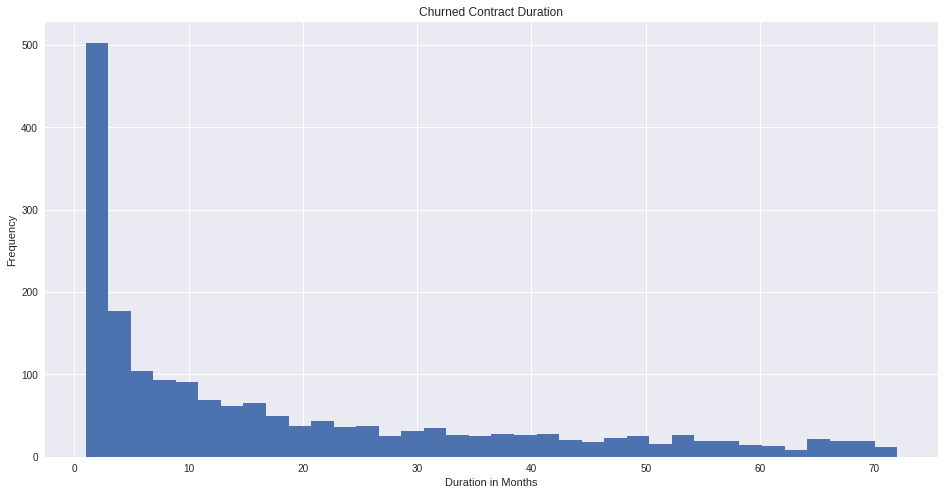

In [63]:
data_complete['contract_duration_months'].plot(kind='hist', bins=36, title='Churned Contract Duration', figsize=[16,8])
plt.xlabel('Duration in Months')
plt.xticks(rotation=0)
plt.show()

A vast majority of churned customers ended their contracts in less than a year, the greatest quantity ending after only a month or two.

Creating a pivot table for the churned column

In [64]:
eda_2 = data_complete.pivot_table(columns='churned',
                               index='contract_type',
                               values='customer_id',
                               aggfunc='count')
                              
eda_2.reset_index(inplace=True)

In [65]:
eda_2

churned,contract_type,0,1
0,Month,2220,1655
1,One year,1307,166
2,Two year,1647,48


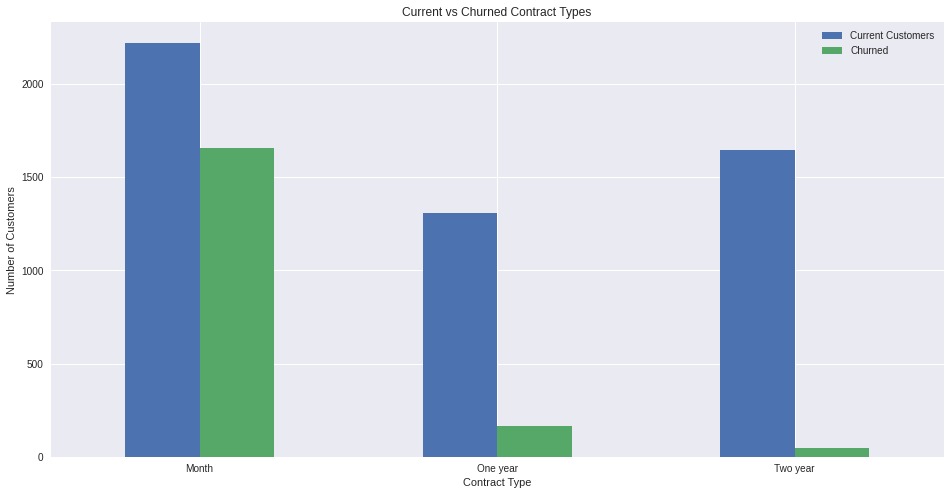

In [66]:
eda_2.plot(kind='bar',
          x='contract_type',
          title='Current vs Churned Contract Types',
          figsize=[16,8],
         )

plt.xticks(rotation= 0)
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])
plt.show()

The highest number of customers that have churned and those still with active service is highest among the customers with Monthly subscription.

A pivot table will be created for the customers that are still active and for those that have churned based 

In [67]:
eda_3 = data_complete.pivot_table(columns='churned',
                               index='payment_method',
                               values='contract_type',
                               aggfunc='count')
                              
eda_3.reset_index(inplace=True)

In [68]:
eda_3

churned,payment_method,0,1
0,Bank transfer (automatic),1286,258
1,Credit card (automatic),1290,232
2,Electronic check,1294,1071
3,Mailed check,1304,308


In [69]:
eda_3 = data_complete.pivot_table(columns='churned',
                               index='payment_method',
                               values='contract_type',
                               aggfunc='count')
                              
eda_3.reset_index(inplace=True)

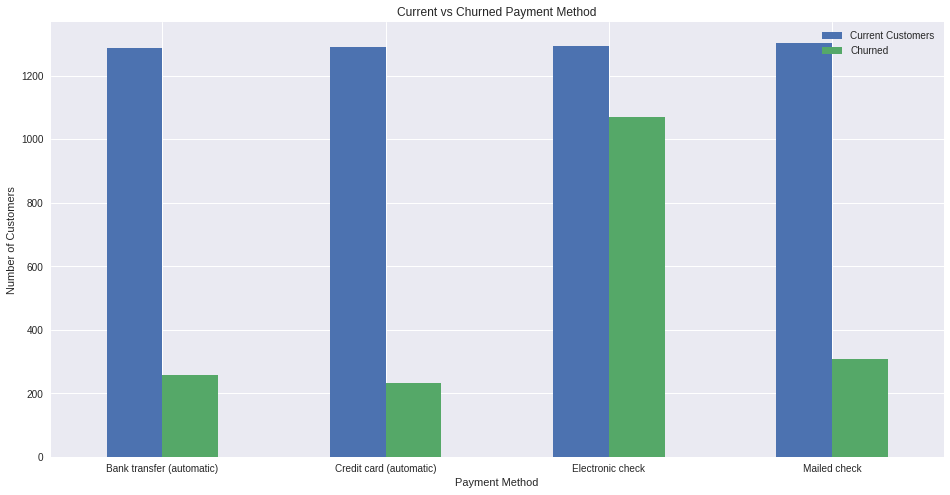

In [70]:
eda_3.plot(kind='bar',
          x='payment_method',
          title='Current vs Churned Payment Method',
          figsize=[16,8])
         

plt.xticks(rotation= 0)
plt.xlabel('Payment Method')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers' ,'Churned'])
plt.show()

The distribution of current customers is relatively equal between the four different payment options. Among the customers that have churned, electronic checks is the most common method that is used to make payment. Automatic bank transfer, automatic credit card charge, and mailed checks make a smaller proportion overall.

In [71]:
eda_4_a = data_complete.pivot_table(columns='churned',
                                index='customer_id',
                                values='monthly_charges')
                               
eda_4_a.reset_index(inplace=True)
eda_4_a.drop(labels='customer_id', axis=1, inplace=True)

eda_4_b = data_complete.pivot_table(columns='churned',
                                index='customer_id',
                                values='total_charges')
                               
eda_4_b.reset_index(inplace=True)
eda_4_b.drop(labels='customer_id', axis=1, inplace=True)

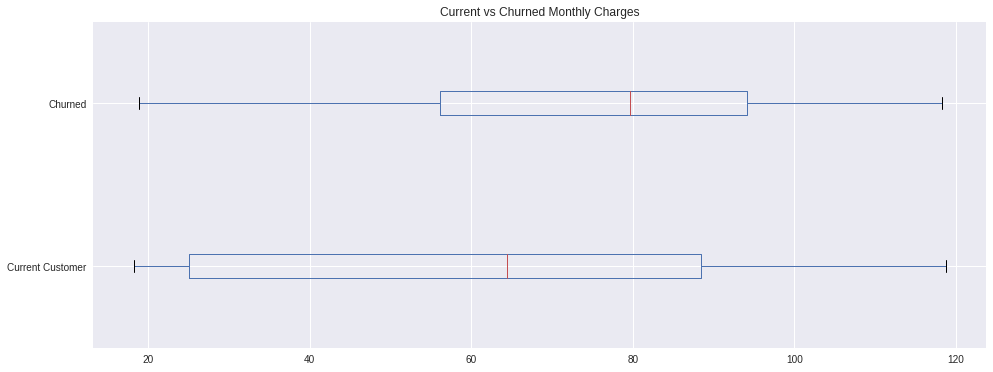

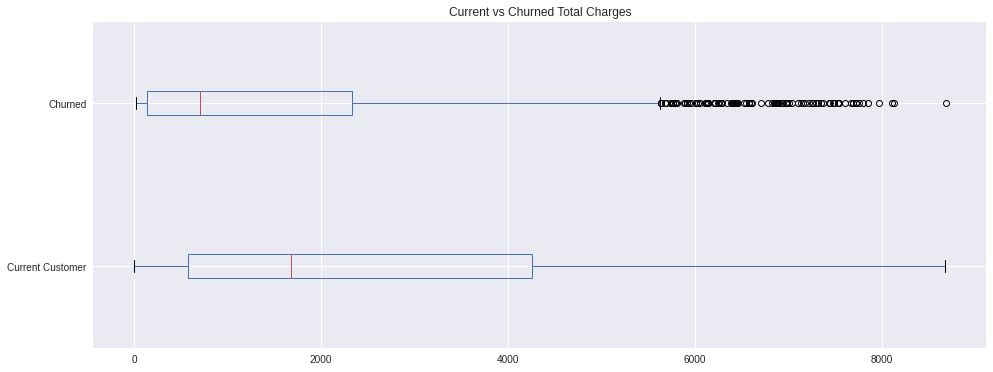

In [72]:
eda_4_a.plot(kind='box',
           figsize=[16,6],
           title='Current vs Churned Monthly Charges',
           vert=False
          )
plt.yticks([1, 2], ['Current Customer', 'Churned'])
eda_4_b.plot(kind='box',
           figsize=[16,6],
           title='Current vs Churned Total Charges',
           vert=False
          )
plt.yticks([1, 2], ['Current Customer', 'Churned'])
plt.show()

Based on the boxplot above, the average monthly contract of customers that have churned is higher than that of current customers. Those that have churned is approximately 80 dollars compared to approximately 64 dollars for those still active.

For total charges are, all current customers fall within the quartile bounds with no outliers, while churned customers have spent less money on average. However, for the upper limits, from approximately $5600 and up are considered outliers for those customers that have churned.

In [73]:
eda_5_a = data_complete.pivot_table(index='gender',
                                    columns='churned',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_5_a.reset_index(inplace=True)

eda_5_b = data_complete.pivot_table(columns='churned',
                               index='senior_citizen',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_5_b.reset_index(inplace=True)

eda_5_c = data_complete.pivot_table(columns='churned',
                               index='partner',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_5_c.reset_index(inplace=True)

eda_5_d = data_complete.pivot_table(columns='churned',
                               index='dependents',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_5_d.reset_index(inplace=True)

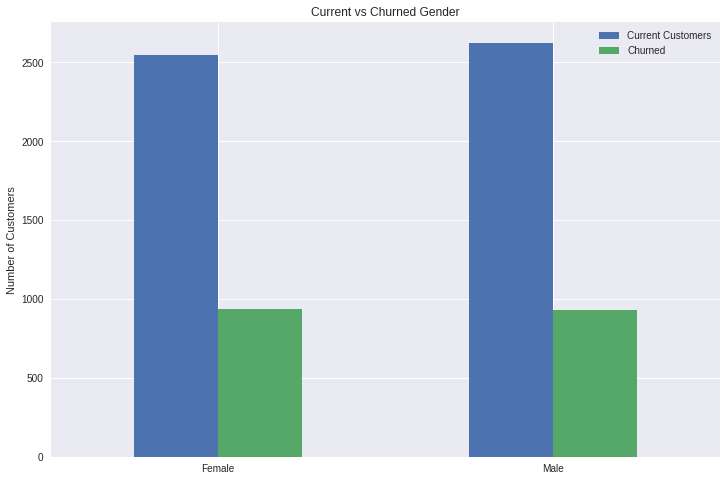

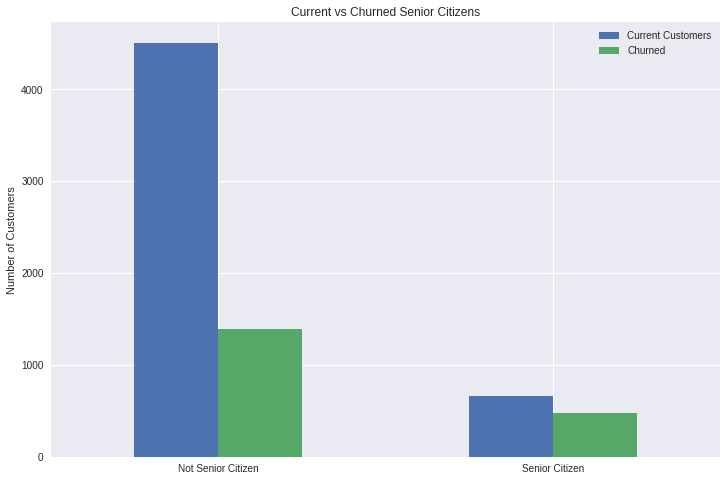

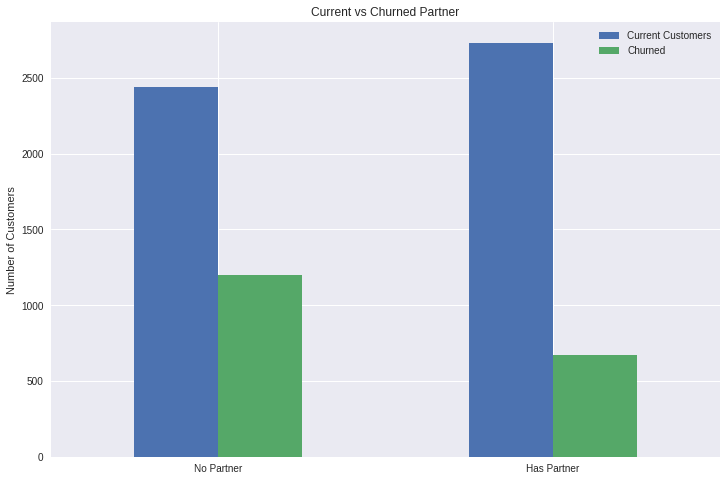

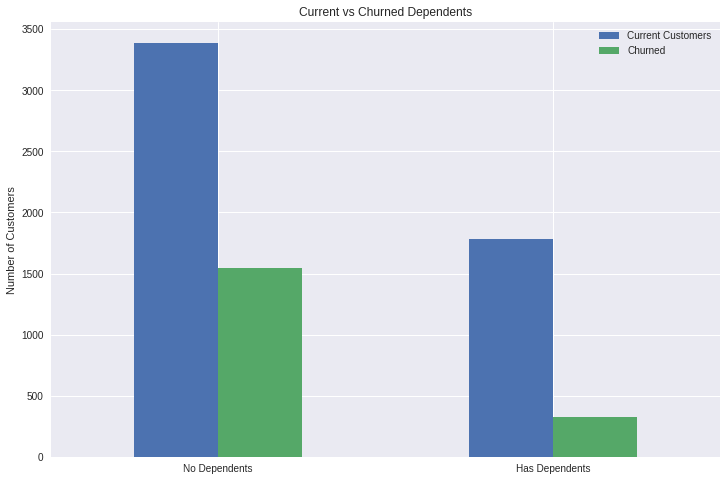

In [74]:
eda_5_a.plot(kind='bar',
           x='gender',
           title='Current vs Churned Gender',
           figsize=[12, 8])
          
plt.xticks([0, 1], ['Female', 'Male'], rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda_5_b.plot(kind='bar',
           x='senior_citizen',
           title='Current vs Churned Senior Citizens',
           figsize=[12, 8])

plt.xticks([0, 1], ['Not Senior Citizen', 'Senior Citizen'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda_5_c.plot(kind='bar',
           x='partner',
           title='Current vs Churned Partner',
           figsize=[12, 8])
          

plt.xticks([0, 1], ['No Partner', 'Has Partner'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda_5_d.plot(kind='bar',
           x='dependents',
           title='Current vs Churned Dependents',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Dependents', 'Has Dependents'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

plt.show()

There is almost the same amount of customers for both current customers and those that churned among the males and females.

For those that are not senior citizens, the ratio of churned clients to current current customers is approximate 1:3. Among the senior citizens the number of those that churned is almost as much as those that are still current. 
This might be caused by a higher number of such customers passing away, therefore their contrants would be cancelled.

There is also a much lower proportion of churned customers where there are dependents or partners reported as well. This could be that those customers/households hold to a steady budget - so having a constant contract is more convenient and beneficial for their social situation.

Lastly, among those with no dependents, the number of those that churned is approximately half the current customers with no dependents. This could be that they were not comfortable with the service, or that they feel it is too expensive for them. Among those that have dependents, the number of those that churned is well below 500. 

In [75]:
eda_6_a = data_complete.pivot_table(columns='contract_type',
                               index='gender',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_6_a.reset_index(inplace=True)

eda_6_b = data_complete.pivot_table(columns='contract_type',
                               index='senior_citizen',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_6_b.reset_index(inplace=True)

eda_6_c = data_complete.pivot_table(columns='contract_type',
                               index='partner',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_6_c.reset_index(inplace=True)

eda_6_d = data_complete.pivot_table(columns='contract_type',
                               index='dependents',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_6_d.reset_index(inplace=True)

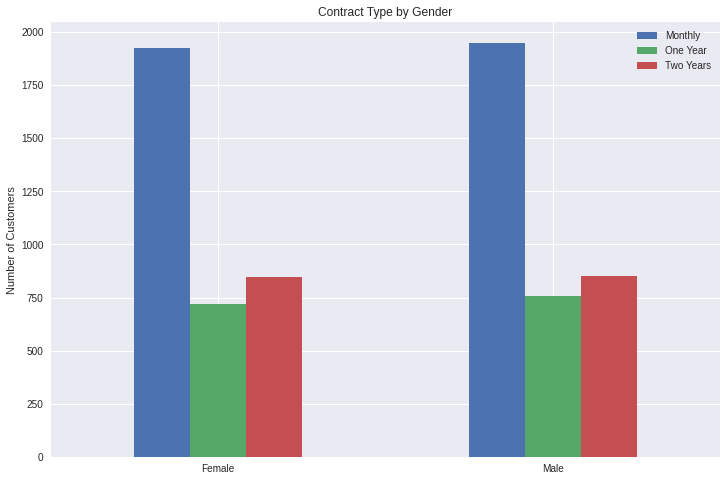

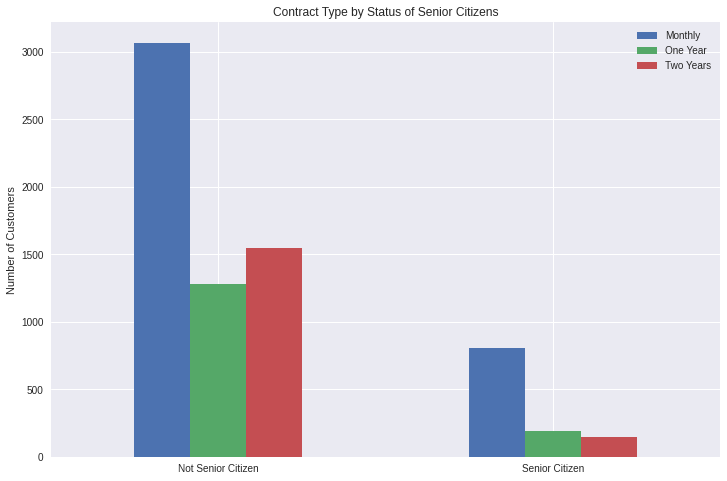

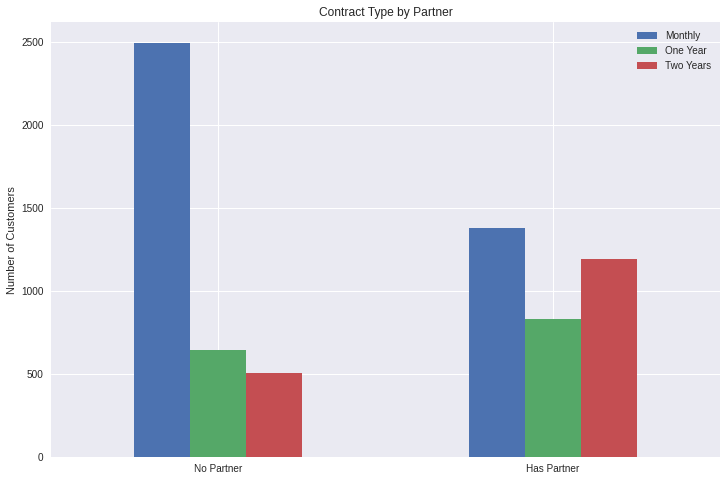

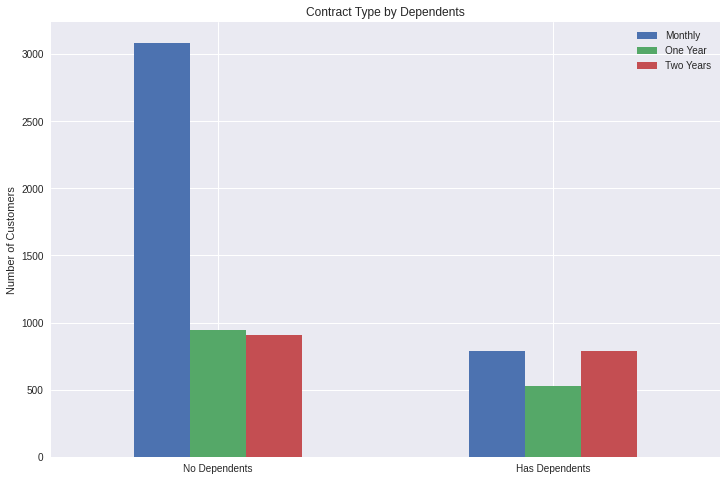

In [76]:
eda_6_a.plot(kind='bar',
           x='gender',
           title='Contract Type by Gender',
           figsize=[12, 8])
          
plt.xticks([0, 1], ['Female', 'Male'], rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Years'])

eda_6_b.plot(kind='bar',
           x='senior_citizen',
           title='Contract Type by Status of Senior Citizens',
           figsize=[12, 8])

plt.xticks([0, 1], ['Not Senior Citizen', 'Senior Citizen'], rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Years'])

eda_6_c.plot(kind='bar',
           x='partner',
           title='Contract Type by Partner',
           figsize=[12, 8])
          

plt.xticks([0, 1], ['No Partner', 'Has Partner'], rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Years'])

eda_6_d.plot(kind='bar',
           x='dependents',
           title='Contract Type by Dependents',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Dependents', 'Has Dependents'], rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Years'])

plt.show()


Monthly contracts are by far the most common and popular option, with one or two year contracts typically being at about a quarter to a third of the amounts.

The exceptions to this are senior citizens- monthly contracts have a slightly higher proportion yet, and with customers that have a partner or dependents, the three contract types are relatively even. The reason for this follows with the churn rate reasoning above. Some senior citizens may not get a long contract as they are planning to pass away sooner than a younger customer, and those customers/households that have partners and/or dependents are more comfortable committing to a longer term contract for the stability it offers.

In [77]:
eda_7 = data_complete.pivot_table(columns='churned',
                               index='internet_service',
                               values='customer_id',
                               aggfunc='count'
                              )
eda_7.reset_index(inplace=True)

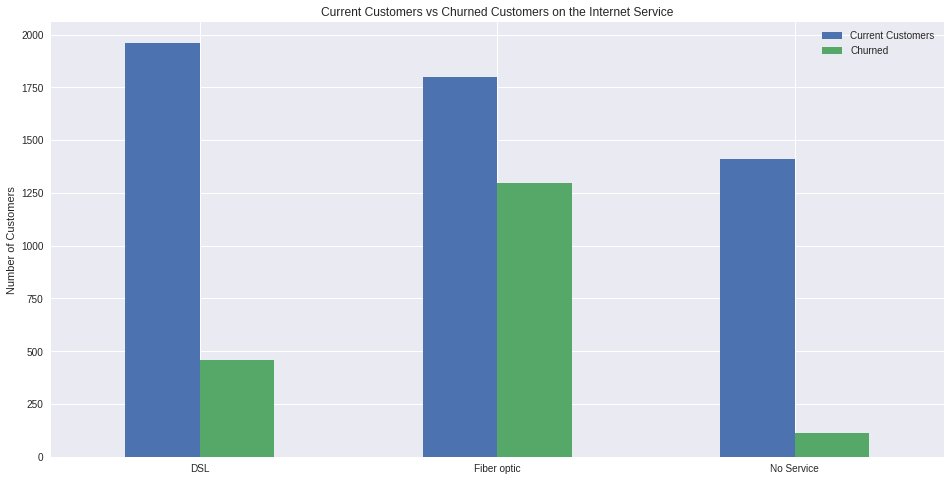

In [78]:
eda_7.plot(kind='bar',
          x='internet_service',
          title='Current Customers vs Churned Customers on the Internet Service',
          figsize=[16,8])
         
#plt.xticks([0, 1, 2], ['DSL', 'Fibre Optic', 'No Service'], rotation = 0)
plt.xticks(rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])
plt.show()

The most popular internet service was DSL, followed by fiber optic, with no internet service as the least popular.

The largest proportion and number of customers that have churned are those customers that had the fiber optic internet service, while the lowest proportion and number of customers that have churned did not have an internet service.

In [79]:
eda_8 = data_complete.pivot_table(columns='contract_type',
                               index='internet_service',
                               values='customer_id',
                               aggfunc='count'
                              )
eda_8.reset_index(inplace=True)

In [80]:
eda_8

contract_type,internet_service,Month,One year,Two year
0,DSL,1223,570,628
1,Fiber optic,2128,539,429
2,No Service,524,364,638


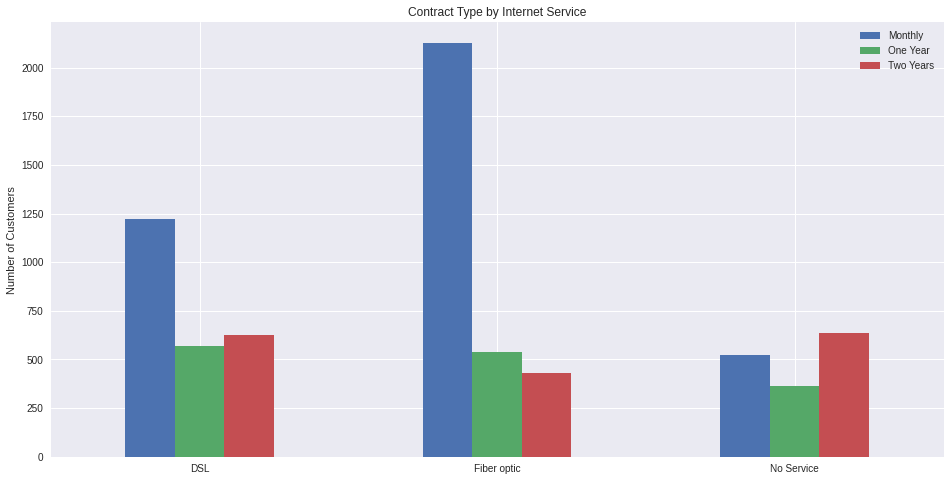

In [81]:
eda_8.plot(kind='bar',
          x='internet_service',
          title='Contract Type by Internet Service',
          figsize=[16,8])
         

plt.xticks(rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Years'])
plt.show()

The monthly plan is the most popular contract type. The total number of the yearly and two-year contracts for DSL and Fiber optic internet types are similar. The most popular option out of the shown combinations is the monthly plan on fiber optic internet type.
Based on previous information presented - monthly contracts and fiber optic internet services yield higher numbers of churned customers, the high degree of short term contracts makes sense.

In [82]:
eda_9_a = data_complete.pivot_table(columns='churned',
                               index='online_security',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_9_a.reset_index(inplace=True)

eda_9_b = data_complete.pivot_table(columns='churned',
                               index='online_backup',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_9_b.reset_index(inplace=True)

eda_9_c = data_complete.pivot_table(columns='churned',
                               index='device_protection',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_9_c.reset_index(inplace=True)

eda_9_d = data_complete.pivot_table(columns='churned',
                               index='tech_support',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_9_d.reset_index(inplace=True)

eda_9_e = data_complete.pivot_table(columns='churned',
                               index='streaming_tv',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_9_e.reset_index(inplace=True)

eda_9_f = data_complete.pivot_table(columns='churned',
                               index='streaming_movies',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_9_f.reset_index(inplace=True)

eda_9_g = data_complete.pivot_table(columns='churned',
                               index='multiple_lines',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_9_g.reset_index(inplace=True)

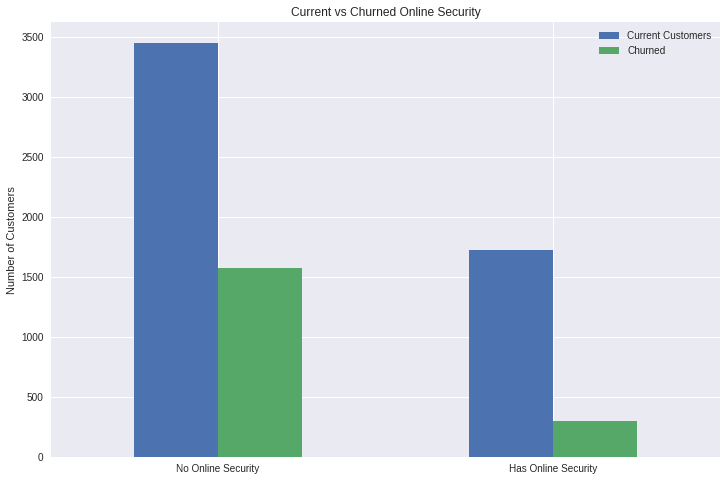

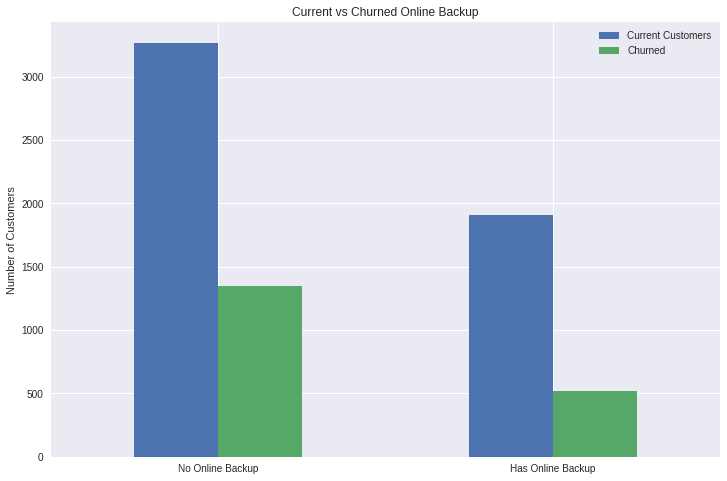

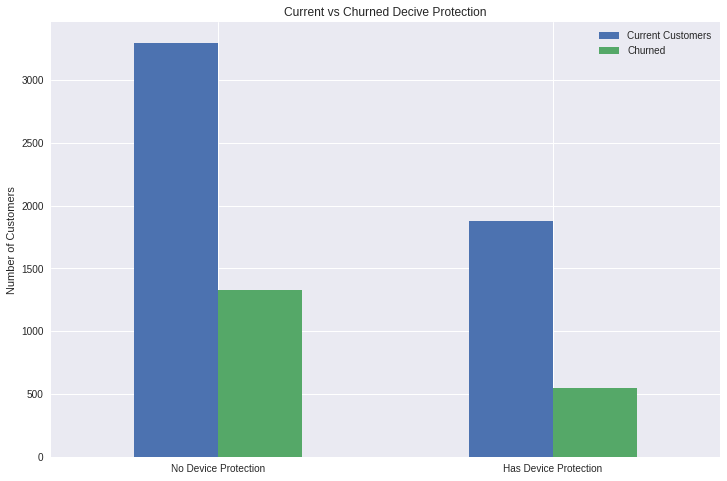

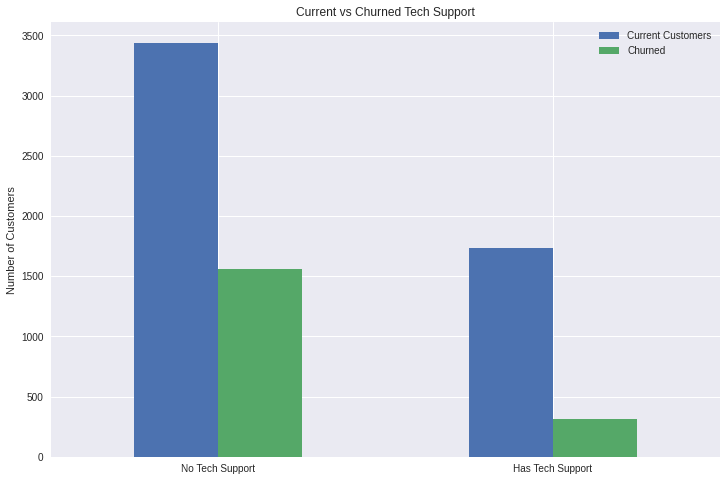

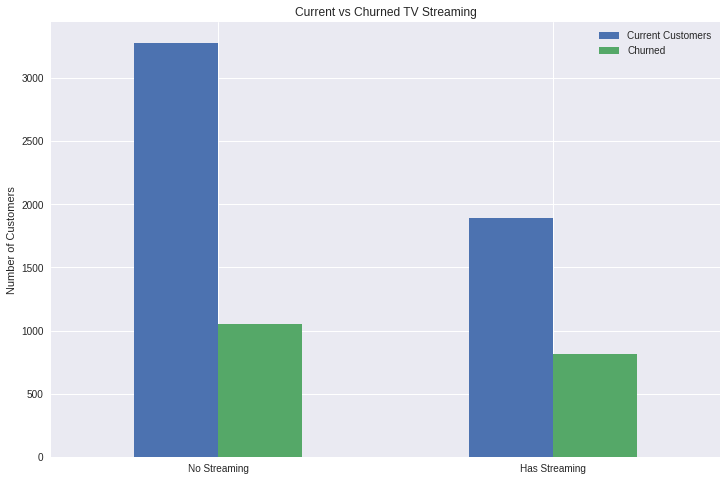

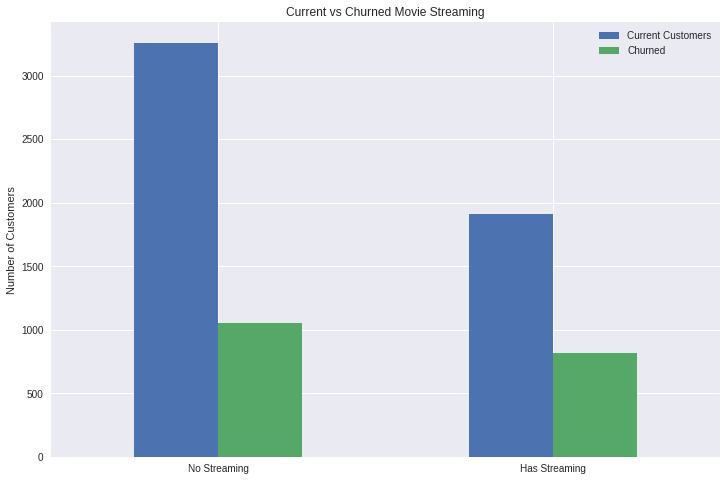

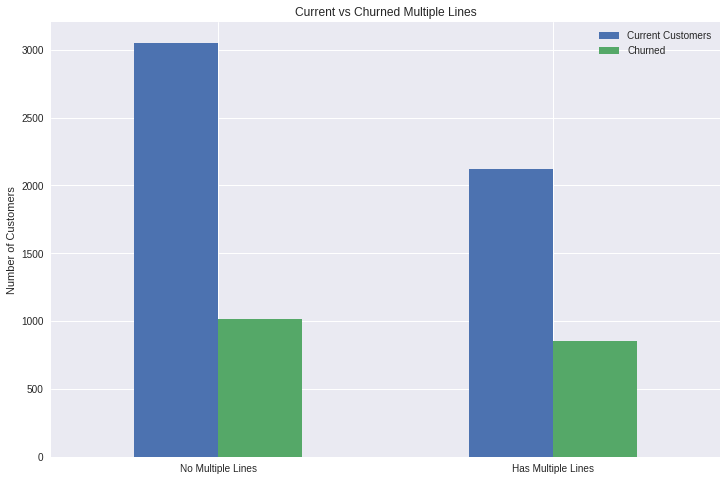

In [83]:
eda_9_a.plot(kind='bar',
           x='online_security',
           title='Current vs Churned Online Security',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Online Security', 'Has Online Security'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda_9_b.plot(kind='bar',
           x='online_backup',
           title='Current vs Churned Online Backup',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Online Backup', 'Has Online Backup'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda_9_c.plot(kind='bar',
           x='device_protection',
           title='Current vs Churned Decive Protection',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Device Protection', 'Has Device Protection'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda_9_d.plot(kind='bar',
           x='tech_support',
           title='Current vs Churned Tech Support',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Tech Support', 'Has Tech Support'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda_9_e.plot(kind='bar',
           x='streaming_tv',
           title='Current vs Churned TV Streaming',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Streaming', 'Has Streaming'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda_9_f.plot(kind='bar',
           x='streaming_movies',
           title='Current vs Churned Movie Streaming',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Streaming', 'Has Streaming'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

eda_9_g.plot(kind='bar',
           x='multiple_lines',
           title='Current vs Churned Multiple Lines',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Multiple Lines', 'Has Multiple Lines'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customers', 'Churned'])

plt.show()

The rate of churn of customers that have online security, online backup, device protection, and tech support is lower than those that do not have. This could be because they have more services that they utilize and benefit from.

The other three, tv streaming, movie streaming, and multiple lines show a slightly higher proportion of churning for those that have such services, howbeit, not to a great degree as they fall within normal proportions that we have seen before. So, there is unlikely to be a correlation between these services individually and the customers churning.

In [84]:
data_complete

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,contract_duration_months,churned,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month,1,Electronic check,29.85,29.85,NaN,0,...,1,0,DSL,0,1,0,0,0,0,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,NaN,0,...,0,0,DSL,1,0,1,0,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month,1,Mailed check,53.85,108.15,2.0,1,...,0,0,DSL,1,1,0,0,0,0,0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,NaN,0,...,0,0,DSL,1,0,1,1,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,Month,1,Electronic check,70.70,151.65,2.0,1,...,0,0,Fiber optic,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,1,Mailed check,84.80,1990.50,NaN,0,...,1,1,DSL,1,0,1,1,1,1,1
7039,2234-XADUH,2014-02-01,NaT,One year,1,Credit card (automatic),103.20,7362.90,NaN,0,...,1,1,Fiber optic,0,1,1,0,1,1,1
7040,4801-JZAZL,2019-03-01,NaT,Month,1,Electronic check,29.60,346.45,NaN,0,...,1,1,DSL,1,0,0,0,0,0,0
7041,8361-LTMKD,2019-07-01,2019-11-01,Month,1,Mailed check,74.40,306.60,4.0,1,...,1,0,Fiber optic,0,0,0,0,0,0,1


In [85]:
eda_10_a = data_complete.pivot_table(columns='contract_type',
                               index='online_security',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_10_a.reset_index(inplace=True)

eda_10_b = data_complete.pivot_table(columns='contract_type',
                               index='online_backup',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_10_b.reset_index(inplace=True)

eda_10_c = data_complete.pivot_table(columns='contract_type',
                               index='device_protection',
                               values='monthly_charges',
                               aggfunc='count'
                               )
eda_10_c.reset_index(inplace=True)

eda_10_d = data_complete.pivot_table(columns='contract_type',
                               index='tech_support',
                               values='monthly_charges',
                               aggfunc='count')
                               
eda_10_d.reset_index(inplace=True)


eda_10_e = data_complete.pivot_table(columns='contract_type',
                               index='streaming_tv',
                               values='monthly_charges',
                               aggfunc='count')
                               
eda_10_e.reset_index(inplace=True)

eda_10_f = data_complete.pivot_table(columns='contract_type',
                               index='streaming_movies',
                               values='monthly_charges',
                               aggfunc='count')
                               
eda_10_f.reset_index(inplace=True)

eda_10_g = data_complete.pivot_table(columns='contract_type',
                               index='multiple_lines',
                               values='monthly_charges',
                               aggfunc='count')
                               
eda_10_g.reset_index(inplace=True)

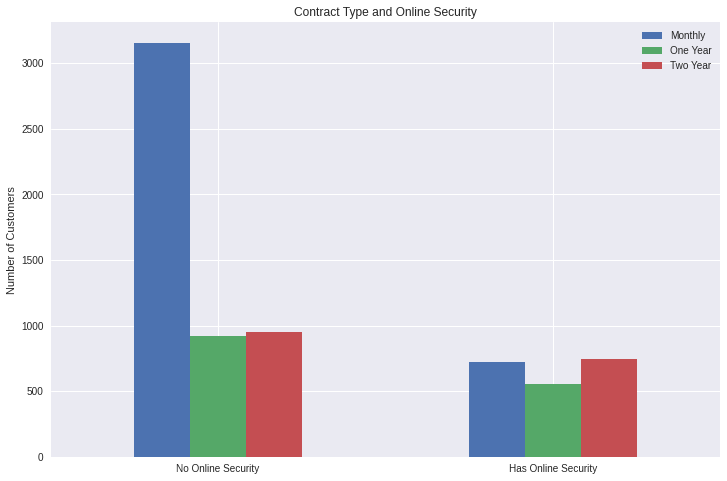

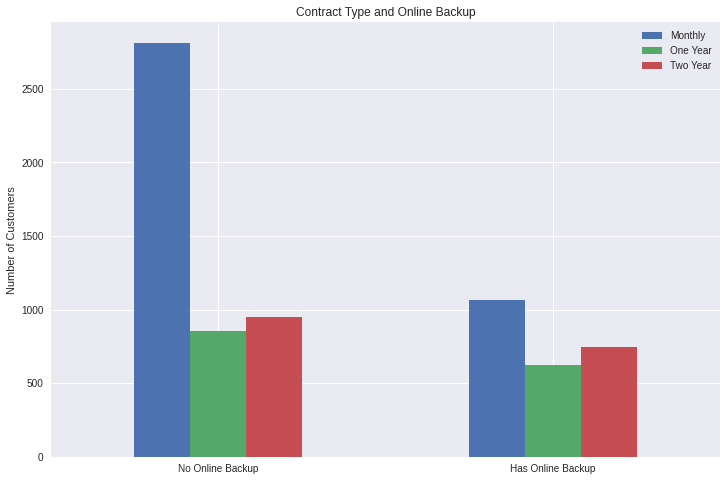

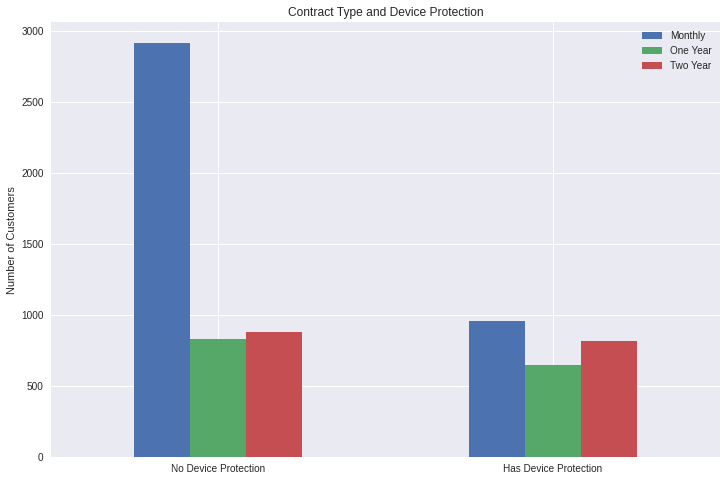

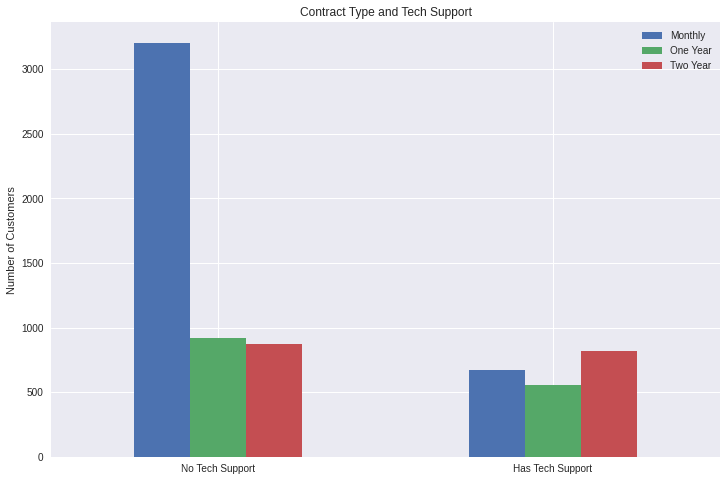

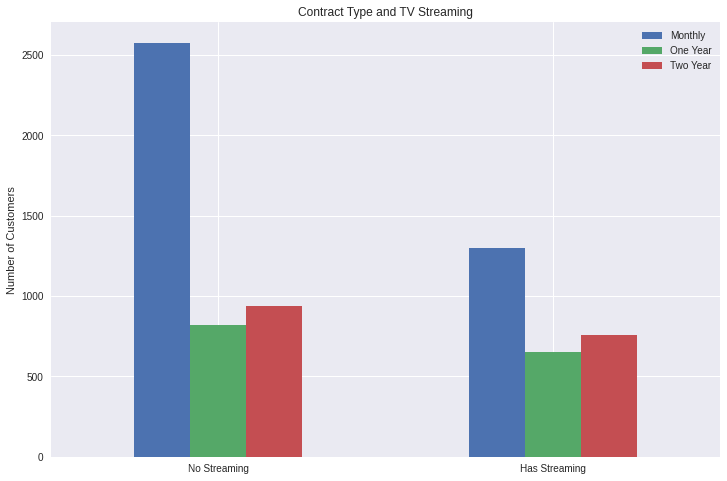

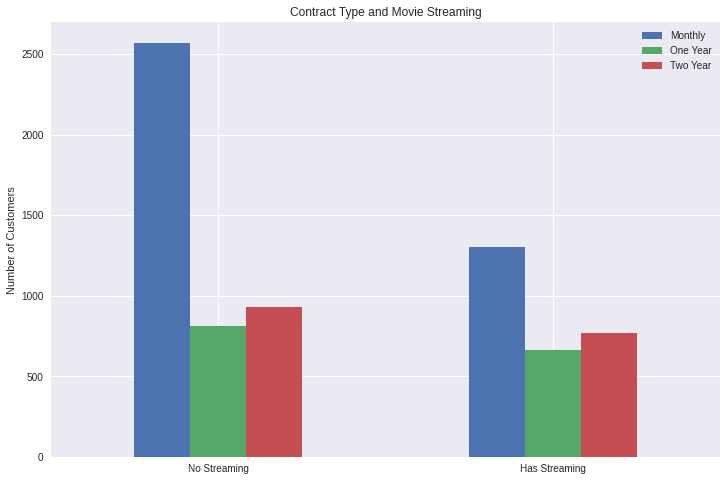

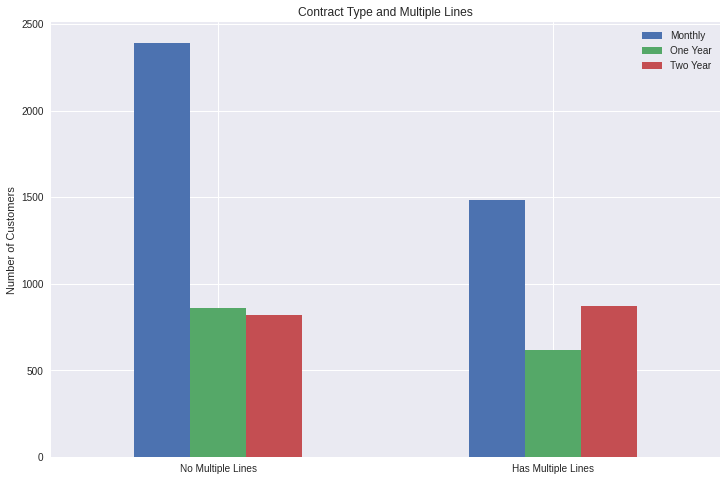

In [86]:
eda_10_a.plot(kind='bar',
           x='online_security',
           title='Contract Type and Online Security',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Online Security', 'Has Online Security'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])

eda_10_b.plot(kind='bar',
           x='online_backup',
           title='Contract Type and Online Backup',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Online Backup', 'Has Online Backup'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])

eda_10_c.plot(kind='bar',
           x='device_protection',
           title='Contract Type and Device Protection',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Device Protection', 'Has Device Protection'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])

eda_10_d.plot(kind='bar',
           x='tech_support',
           title='Contract Type and Tech Support',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Tech Support', 'Has Tech Support'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])

eda_10_e.plot(kind='bar',
           x='streaming_tv',
           title='Contract Type and TV Streaming',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Streaming', 'Has Streaming'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])

eda_10_f.plot(kind='bar',
           x='streaming_movies',
           title='Contract Type and Movie Streaming',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Streaming', 'Has Streaming'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])

eda_10_g.plot(kind='bar',
           x='multiple_lines',
           title='Contract Type and Multiple Lines',
           figsize=[12,8]
          )

plt.xticks([0, 1], ['No Multiple Lines', 'Has Multiple Lines'],rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])



plt.show()

A higher proportion of customers that have one or two year contracts have additional services such as online security or tech support. There is a slightly higher than normal proportion for services like streaming and multiple lines as well, but not to the degree that the contraact types for those that have such services are comparable.

In [87]:
eda_11 = data_complete.pivot_table(columns='churned',
                                index='multiple_lines',
                                values='customer_id',
                                aggfunc='count'
                               )
eda_11.reset_index(inplace=True)

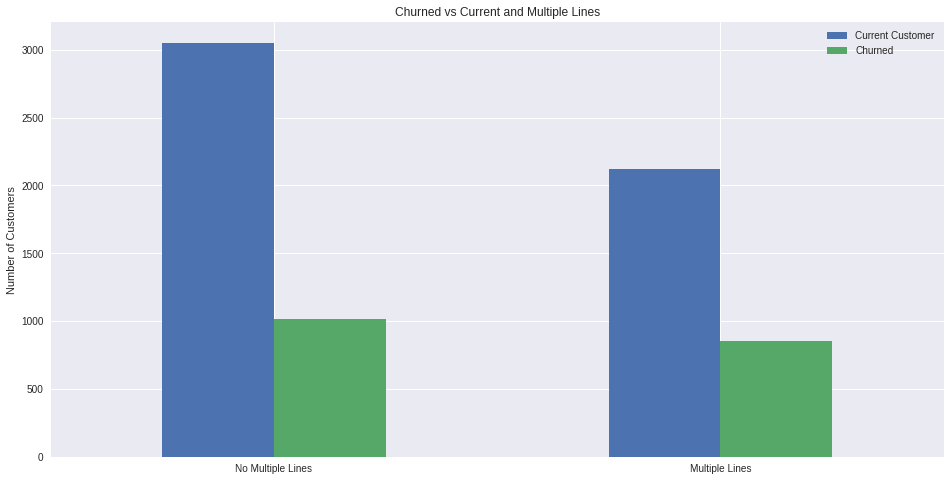

In [89]:
eda_11.plot(kind='bar',
           x='multiple_lines',
           title='Churned vs Current and Multiple Lines',
           figsize=[16,8],
          )

plt.xticks([0, 1], ['No Multiple Lines', 'Multiple Lines'], rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Current Customer', 'Churned'])
plt.show()

The number of customers with single lines that churned is quite higher than those those with multiple lines. Conversely, among the current customers, the number of those that have single lines is more than those that have multiple lines. This data shows that, it's unlikely that there is any correlation between churned contracts and having multiple lines.

In [90]:
eda_12 = data_complete.pivot_table(columns='contract_type',
                                index='multiple_lines',
                                values='customer_id',
                                aggfunc='count'
                               )
eda_12.reset_index(inplace=True)

In [91]:
eda_12

contract_type,multiple_lines,Month,One year,Two year
0,0,2393,857,822
1,1,1482,616,873


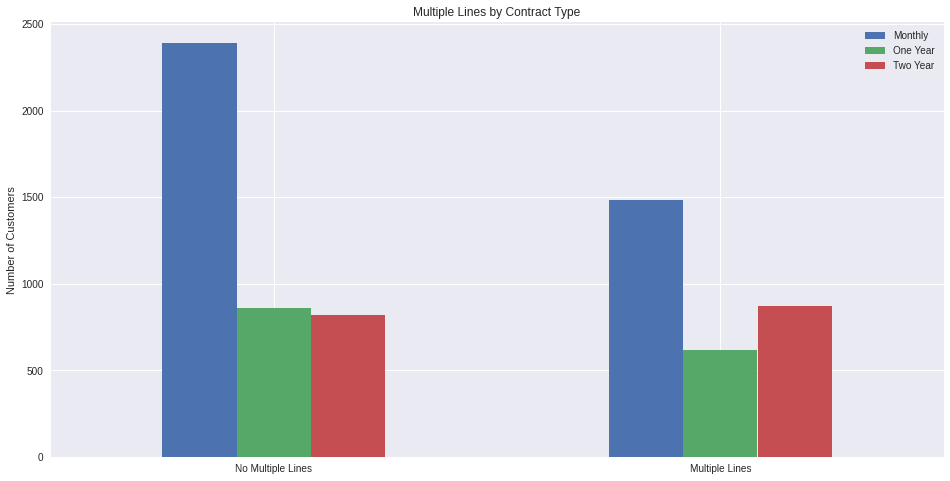

In [92]:
eda_12.plot(kind= 'bar',
            x= 'multiple_lines',
            title = 'Multiple Lines by Contract Type',
           figsize=[16,8],
          )

plt.xticks([0, 1], ['No Multiple Lines', 'Multiple Lines'], rotation= 0)
plt.xlabel('')
plt.ylabel('Number of Customers')
plt.legend(['Monthly', 'One Year', 'Two Year'])
plt.show()

The main difference between customers with single lines and those with multiple lines is that those with multiple lines have noticeably less monthly contracts.
The number of yearly contracts are within one to two hundred customers for each type, and the number for the two-year contracts are similar. 

## Model Training

### Load libraries for Machine Learning

In [93]:
!pip install --user imbalanced-learn

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [95]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [96]:
from lightgbm import LGBMClassifier

### Feature Engineering

In [97]:
data_complete.head()

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,contract_duration_months,churned,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month,1,Electronic check,29.85,29.85,NaN,0,...,1,0,DSL,0,1,0,0,0,0,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,NaN,0,...,0,0,DSL,1,0,1,0,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month,1,Mailed check,53.85,108.15,2.0,1,...,0,0,DSL,1,1,0,0,0,0,0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,NaN,0,...,0,0,DSL,1,0,1,1,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,Month,1,Electronic check,70.70,151.65,2.0,1,...,0,0,Fiber optic,0,0,0,0,0,0,0


We create new column based on internet_service column. This column will be for those that do not use any internet services.

In [98]:
data_complete['with_internet'] = data_complete['internet_service']

In [99]:
data_complete['with_internet'] = data_complete['with_internet'].where(data_complete['with_internet'] != 'DSL', 1)
data_complete['with_internet'] = data_complete['with_internet'].where(data_complete['with_internet'] != 'Fiber optic', 1)
data_complete['with_internet'] = data_complete['with_internet'].where(data_complete['with_internet'] != 'No Service', 0)
data_complete['with_internet'] = data_complete['with_internet'].astype(int)

Next we define the length of the contract based on the latest begin date

In [100]:
# define contract length based on latest begin_date
recent = data_complete['begin_date'].max()
data_complete['end_date'] = data_complete['end_date'].fillna(recent)
duration = ((data_complete['end_date'] - data_complete['begin_date']) / np.timedelta64(1, 'M'))
data_complete['tenure'] = duration.round()
data_complete['tenure'] = data_complete['tenure'].astype(int)

In [101]:
# Find difference of monthly_charges * tenure and total_charges
standard_billed = data_complete['monthly_charges'] * data_complete['tenure']
data_complete['charges_difference'] = data_complete['total_charges'] - standard_billed

Our next step will be to remove churned outliers and replace them with median churned values

In [102]:

churned_df = data_complete[data_complete['churned'] == 1]
churned_median = churned_df['total_charges'].median()
churned_std = churned_df['total_charges'].std()

#df_complete['total_charges'] = df_complete['total_charges'].where((df_complete['churned'] > 0) & (df_complete['total_charges'] > (churned_median + (churned_std * 2))), churned_median)

for index, row in data_complete.iterrows():
    
    if row['churned'] == 1:
        if row['total_charges'] > np.abs(row['total_charges'] - churned_median) > 3 * churned_std:
            row['total_charges'] = churned_median + 3 * churned_std

We will drop unused columns, then perform One Hot encoding

In [103]:
data_full = data_complete.drop(['customer_id', 'begin_date', 'end_date', 'contract_duration_months'], axis=1)
#data_ohe = pd.get_dummies(data_full, drop_first=True)

### Train / Test Split

In [104]:
data_full.head()

,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,churned,gender,senior_citizen,partner,dependents,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,with_internet,tenure,charges_difference
0,Month,1,Electronic check,29.85,29.85,0,0,0,1,0,...,0,1,0,0,0,0,0,1,1,0.00
1,One year,0,Mailed check,56.95,1889.50,0,1,0,0,0,...,1,0,1,0,0,0,0,1,34,-46.80
2,Month,1,Mailed check,53.85,108.15,1,1,0,0,0,...,1,1,0,0,0,0,0,1,2,0.45
3,One year,0,Bank transfer (automatic),42.30,1840.75,0,1,0,0,0,...,1,0,1,1,0,0,0,1,45,-62.75
4,Month,1,Electronic check,70.70,151.65,1,0,0,0,0,...,0,0,0,0,0,0,0,1,2,10.25


In [105]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   contract_type       7043 non-null   object 
 1   paperless_billing   7043 non-null   int64  
 2   payment_method      7043 non-null   object 
 3   monthly_charges     7043 non-null   float64
 4   total_charges       7043 non-null   float64
 5   churned             7043 non-null   int64  
 6   gender              7043 non-null   int64  
 7   senior_citizen      7043 non-null   int64  
 8   partner             7043 non-null   int64  
 9   dependents          7043 non-null   int64  
 10  internet_service    7043 non-null   object 
 11  online_security     7043 non-null   int64  
 12  online_backup       7043 non-null   int64  
 13  device_protection   7043 non-null   int64  
 14  tech_support        7043 non-null   int64  
 15  streaming_tv        7043 non-null   int64  
 16  stream

In [106]:
train, test = train_test_split(data_full, test_size=0.25, random_state = 134678, stratify = data_full['churned']) 

categorical_columns = ['contract_type', 'payment_method', 'internet_service' ]
encoder = OrdinalEncoder()
encoder.fit(train[categorical_columns])
train[categorical_columns] = encoder.transform(train[categorical_columns])
test[categorical_columns] = encoder.transform(test[categorical_columns])

#### Verifying the Distriibution

In [107]:
display(train['churned'].value_counts())
display(test['churned'].value_counts())

0    3880
1    1402
Name: churned, dtype: int64

0    1294
1     467
Name: churned, dtype: int64

#### Defining Features and Targets

In [108]:
feat_train = train.drop('churned', axis = 1)
target_train = train['churned']
feat_test = test.drop('churned', axis = 1)
target_test = test['churned']

feat_train, target_train = SMOTE().fit_resample(feat_train, target_train)

#### Scaling Numerical Columns

In [109]:
numeric = ['monthly_charges', 'total_charges', 'charges_difference']

scaler = StandardScaler()
scaler.fit(feat_train[numeric]) 
feat_train[numeric] = scaler.transform(feat_train[numeric])
feat_test[numeric] = scaler.transform(feat_test[numeric])

### Training Models

#### Logistic Regression

In [110]:
lr_model = LogisticRegression(solver = 'liblinear')
scores = cross_val_score(lr_model, feat_train, target_train, cv=8, scoring='roc_auc')
lr_train_score = sum(scores) / len(scores)

In [111]:
lr_model.fit(feat_train, target_train)

lr_predictions_test = lr_model.predict(feat_test)

lr_test_score = roc_auc_score(target_test, lr_predictions_test)

In [112]:
display("Logistic Regression Training ROC-AUC:", lr_train_score)
display("Logistic Regression Test ROC-AUC:", lr_test_score)

'Logistic Regression Training ROC-AUC:'

0.8882981719630142

'Logistic Regression Test ROC-AUC:'

0.7475020602418012

The score of the Logistic Regression model will be used as a baseline for the performance of the models trained below.

#### Decision Tree Classifier

We will tune the hyperparameters to get the one with the best cross-validation score, then we train our model with it.

In [162]:
### Tuning Hyperparameters

dtc_model = None
dtc_train_score = 0
dtc_best_depth = 0

for depth in range(1, 31):
    model_dtr = DecisionTreeClassifier(random_state=134678, max_depth=depth)
    scores = cross_val_score(model_dtr, feat_train, target_train, cv=8, scoring='roc_auc')
    result  = scores.mean()
    if result > dtc_train_score:
        dtc_model = model_dtr
        dtc_train_score = result
        dtc_best_depth = depth

In [163]:
mod_DTR = DecisionTreeClassifier(max_depth = 5, random_state = 134678)
mod_DTR.fit(feat_train, target_train)
predictions = mod_DTR.predict(feat_test)
dtc_test_scorer = roc_auc_score(target_test, predictions)

In [164]:
print("Decision Tree Classifier Depth:", dtc_best_depth)
print("Decision Tree Classifier Training ROC-AUC Score is:", dtc_train_score)
print("Decission Tree Classifier Test ROC-AUC:", dtc_test_scorer)

Decision Tree Classifier Depth: 8
Decision Tree Classifier Training ROC-AUC Score is: 0.8822885003719844
Decission Tree Classifier Test ROC-AUC: 0.7078792251505052


The Decision Tree Classifier ended with a lower ROC-AUC score than the Logistic Regression model. This along with it's low score indicates it is not a good predictive model for this task.

#### Random Forest Classfier

In [165]:
### Tuning Hyperparameters

rfc_model = None
rfc_train_score = 0
rfc_best_est = 0

for est in range(100, 151):
    model = RandomForestClassifier(random_state = 134678, n_estimators=est)
    model.fit(feat_train, target_train)
    scores = cross_val_score(model, feat_train, target_train, cv=8, scoring='roc_auc')
    result = scores.mean()
    if result > rfc_train_score:
        rfc_train_score = result
        rfc_best_est = est
        rfc_model = model

In [166]:
rfc_predictions_test = rfc_model.predict(feat_test)

rfc_test_score = roc_auc_score(target_test, rfc_predictions_test)

In [167]:
print("Random Forest Classifier Trees:", rfc_best_est)
print("Random Forest Classifier Training ROC-AUC:", rfc_train_score)
print("Random Forest Classifier Test ROC-AUC:", rfc_test_score)

Random Forest Classifier Trees: 150
Random Forest Classifier Training ROC-AUC: 0.9292945584015304
Random Forest Classifier Test ROC-AUC: 0.732166083620995


The Random Forest Classifier did not perform as good as the Logistic Regression model. The low score indicates that it is not a good predictor for this task.

#### LightGBM Classifier

In [172]:
### Tuning Hyperparameters

bdtc_model = None
bdtc_leaves = 0
bdtc_learning_rate = 0
bdtc_train_score = 0

for learn in range (1, 21):
    rate = learn/20
    for est in range (2, 21):
        model = LGBMClassifier(boosting_type='gbdt', 
                               num_leaves=est, 
                               max_depth=50, 
                               learning_rate=rate, 
                               n_estimators= 20, 
                               objective='binary' 
                              )
        model.fit(feat_train, target_train)
        scores = cross_val_score(model, feat_train, target_train, cv=8, scoring='roc_auc')
        result = sum(scores) / len(scores)
        if result > bdtc_train_score:
            bdtc_train_score = result
            bdtc_leaves = est
            bdtc_learning_rate = rate
            bdtc_model = model

In [173]:
bdtc_predictions_test = bdtc_model.predict(feat_test)

bdtc_test_score = roc_auc_score(target_test, bdtc_predictions_test)

In [174]:
display("Gradient Boosted Decission Tree Classifier Tree leaves:", bdtc_leaves)
display("Gradient Boosted Decission Tree Classifier Tree learning rate:", bdtc_learning_rate)

display("Gradient Boosted Decission Tree Classifier Training ROC-AUC:", bdtc_train_score)
display("Gradient Boosted Decission Tree Classifier Test ROC-AUC:", bdtc_test_score)

'Gradient Boosted Decission Tree Classifier Tree leaves:'

20

'Gradient Boosted Decission Tree Classifier Tree learning rate:'

0.35

'Gradient Boosted Decission Tree Classifier Training ROC-AUC:'

0.9313497714953768

'Gradient Boosted Decission Tree Classifier Test ROC-AUC:'

0.7420999242095787

#### LightGBM Gradient Boosted DART Classifier

In [175]:
### Tuning Hyperparameters

dart_model = None
dart_leaves = 0
dart_learning_rate = 0
dart_train_score = 0

for learn in range (1, 21):
    rate = learn/20
    for est in range (2, 31):
        model = LGBMClassifier(boosting_type='dart', 
                               num_leaves=est, 
                               max_depth=50, 
                               learning_rate=rate, 
                               n_estimators= 30, 
                               objective='binary'
                              )
        model.fit(feat_train, target_train)
        scores = cross_val_score(model, feat_train, target_train, cv=8, scoring='roc_auc')
        result = sum(scores) / len(scores)
        if result > dart_train_score:
            dart_train_score = result
            dart_leaves = est
            dart_learning_rate = rate
            dart_model = model    

In [176]:
dart_predictions = dart_model.predict(feat_test)

dart_test_score = roc_auc_score(target_test, dart_predictions)

In [177]:
display("Gradiant Boosted DART Classifier Tree leaves:", dart_leaves)
display("Gradiant Boosted DART Classifier Tree learning rate:", dart_learning_rate)

display("Gradiant Boosted DART Classifier Training ROC-AUC:", dart_train_score)
display("Gradiant Boosted DART Classifier Test ROC-AUC:", dart_test_score)

'Gradiant Boosted DART Classifier Tree leaves:'

29

'Gradiant Boosted DART Classifier Tree learning rate:'

0.25

'Gradiant Boosted DART Classifier Training ROC-AUC:'

0.9329575406525668

'Gradiant Boosted DART Classifier Test ROC-AUC:'

0.728125031027738

### CatBoost

In [114]:
CBR_model = CatBoostClassifier()
random_state = 12345

In [148]:
CBR_model = CatBoostClassifier()
parameters={'depth': [6, 8, 10],
           'learning_rate': [0.5, 0.1],
           'l2_leaf_reg': [2, 4],
           'iterations': [10, 30],
           'loss_function': ['Logloss'],
           'random_seed': [random_state]} #our dictionary of hyperparameters that will be looped through when 
                                          #we feed them to GridSearch
grid = GridSearchCV(estimator = CBR_model, param_grid = parameters, cv = 5, n_jobs=-1, verbose=0)

grid.fit(feat_train, target_train) #fits our training unencoded data into our grid instance

best_par = grid.best_params_

0:	learn: 0.4813123	total: 4.81ms	remaining: 43.3ms
1:	learn: 0.4091789	total: 9.7ms	remaining: 38.8ms
2:	learn: 0.3557145	total: 14.6ms	remaining: 34.1ms
3:	learn: 0.3263664	total: 19.4ms	remaining: 29.1ms
4:	learn: 0.3126464	total: 24.2ms	remaining: 24.2ms
5:	learn: 0.2984381	total: 29.6ms	remaining: 19.7ms
6:	learn: 0.2904218	total: 34.4ms	remaining: 14.7ms
7:	learn: 0.2835994	total: 39.3ms	remaining: 9.82ms
8:	learn: 0.2768121	total: 44.2ms	remaining: 4.91ms
9:	learn: 0.2713772	total: 49.5ms	remaining: 0us
0:	learn: 0.4833959	total: 4.78ms	remaining: 43ms
1:	learn: 0.4173807	total: 9.4ms	remaining: 37.6ms
2:	learn: 0.3655060	total: 14.3ms	remaining: 33.3ms
3:	learn: 0.3328618	total: 19ms	remaining: 28.6ms
4:	learn: 0.3203826	total: 23.8ms	remaining: 23.8ms
5:	learn: 0.3068898	total: 28.5ms	remaining: 19ms
6:	learn: 0.3006976	total: 33.3ms	remaining: 14.3ms
7:	learn: 0.2931226	total: 38ms	remaining: 9.51ms
8:	learn: 0.2872009	total: 42.9ms	remaining: 4.77ms
9:	learn: 0.2834799	total

In [149]:
print('Best score across all searched parameters', grid.best_score_)
print('Best parameters:', best_par)

Best score across all searched parameters 0.8286082474226804
Best parameters: {'depth': 6, 'iterations': 30, 'l2_leaf_reg': 2, 'learning_rate': 0.5, 'loss_function': 'Logloss', 'random_seed': 12345}


Next, we train our CatBoost classifier model using the best hyperparameter settings

In [151]:
#CatBoost Model training 

CBR_model = CatBoostClassifier(depth = 6,
                              iterations = 30,
                              l2_leaf_reg = 2,                              
                              loss_function = 'Logloss', 
                              random_seed = random_state)

In [152]:
CBR_model.fit(feat_train, target_train, verbose = False, plot = False)

In [153]:
CBR_model_pred = CBR_model.predict(feat_train)

CBR_test_score = roc_auc_score(target_train, CBR_model_pred)

CBR_test_score

0.8242268041237113

In [154]:
CBR_model_pred = CBR_model.predict(feat_test)

CBR_test_score = roc_auc_score(target_test, CBR_model_pred)

CBR_test_score

0.7639244213947423

## Project Report

This solution report is a compilation of all the findings from the data that was provided by the telecom operator, Interconnect. After working on the project to help forecast the clients that will churn, I was able to create a model that has a ROC-AUC score that was above 0.75. To execute this project, we laid out a plan, which guided us from the beginning to the end of the project. 

In **Data Preprocessing**, we:
   * converted the columns into the right datatypes
   * changed the column names to lower cases
   * changed the Yes values to 1 and the No to 0
   * Merged the datasets on the userID
   * Filled in the missing rows
   * Took out duplicates

In **Exploratory Data Analysis**, we:
- Explored the Dataset by Checking for the correlation between the current and churned customers based on:
   * Contract Type
   * Payment method
   * total charges
   * monthly charges
   * gender
   * dependents
   * Partners
   * Internet service
   * Online Security
   * device protection
   * online backup
   * tech support
 

We analyzed the data and found that the clients who left typically paid higher monthly charges. Most of the clients who left were paying electronically, so we may want to look at that system more critically. 


### Model Training

During the training of the dataset we imported the necessary libraries that we would use to train and test our dataset. Then we conducted Feature Engineering.
After Feature Engineering, we created an upper bound limit for the **total charges** when filtering out outliers. The upper limit was set at median plus 3 standard deviations from the median.
Our test size was 25% of our dataset.
Next, we scaled our features, and trained several models. The models that we trained were: Logistic Regression, Decision Tree Classifier, Random Forest, LGBM Classifier.

After cross validation, the best score (0.84) on the training set belonged to the LGBM model. We tested it on the test set and got a AUC-ROC score of ~71.

### Remediation
To improve the score of our models we did the following:
- Performed Ordinal Encoding on the categorical features
- Amended the class imbablance by adjusting the weights
- Added an additional model - CatBoost Model

After performing these steps above, the best score (0.82) on the training set belonged to the CatBoost model. We tested it on the test set and got an AUC-ROC score of ~76.